# PROYECTO FINAL PARTE 2: ELIMINATORIA DE CONMEBOL

In [1]:
import pandas as pd
import numpy as np
from pandasql import sqldf
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from itertools import combinations

%matplotlib inline

In [2]:
# Se emplea SQL para facilitar el filtrado en los dataframes de Pandas.
query = lambda q : slqdf(q, globals())

In [3]:
# Se importan los datos de las plantillas de cada selección.
selecciones_conmebol = pd.read_csv('datos_fifa/SELECCIONES_CONMEBOL.csv')
selecciones_conmebol['Overall'] = selecciones_conmebol['Overall'].fillna(65)

# Se importa el historial de los enfrentamientos entre estas selecciones, desde que existe
# el Ranking FIFA (diciembre de 1992).
historico_conmebol = pd.read_csv('datos_fifa/HISTORICO_CONMEBOL.csv')

# Se importa la estructura del eliminatoria_conmebol final.
eliminatoria_conmebol = pd.read_csv('datos_fifa/ELIMINATORIA_CONMEBOL.csv')

In [4]:
eliminatoria_conmebol

,equipo,grupo,ranking FIFA
0,Argentina,UNICO,9
1,Bolivia,UNICO,75
2,Brasil,UNICO,3
3,Chile,UNICO,17
4,Colombia,UNICO,10
5,Ecuador,UNICO,63
6,Paraguay,UNICO,41
7,Peru,UNICO,21
8,Uruguay,UNICO,5
9,Venezuela,UNICO,25


In [5]:
historico_conmebol.head()

,fecha,local,visitante,goles_local,goles_visita,torneo,ciudad,pais_x,neutral,difgol,gana_local,gana_visita,ranking_local,abrev_local,ranking_visitante,abrev_visitante,dif_ranking
0,1993-07-18,Venezuela,Bolivia,1.0,7.0,FIFA World Cup qualification,Puerto Ordaz,Venezuela,0.0,-6.0,0.0,1.0,94.0,VEN,59.0,BOL,35.0
1,1993-07-18,Ecuador\n,Brasil,0.0,0.0,FIFA World Cup qualification,Guayaquil,Ecuador,0.0,0.0,0.0,0.0,35.0,ECU,8.0,BRA,27.0
2,1993-07-25,Bolivia,Brasil,2.0,0.0,FIFA World Cup qualification,La Paz,Bolivia,0.0,2.0,1.0,0.0,59.0,BOL,8.0,BRA,51.0
3,1993-07-25,Venezuela\n,Uruguay,0.0,1.0,FIFA World Cup qualification,San Cristóbal,Venezuela,0.0,-1.0,0.0,1.0,94.0,VEN,22.0,URU,72.0
4,1993-08-01,Colombia\n,Paraguay,0.0,0.0,FIFA World Cup qualification,Barranquilla,Colombia,0.0,0.0,0.0,0.0,19.0,COL,67.0,PAR,-48.0


In [6]:
selecciones_conmebol.head()

,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,214584.0,F. Armani,31.0,https://cdn.sofifa.org/players/4/19/214584.png,Argentina,https://cdn.sofifa.org/flags/52.png,80.0,80.0,River Plate,https://cdn.sofifa.org/teams/2/light/1876.png,...,20.0,48.0,10.0,13.0,18.0,79.0,74.0,69.0,79.0,84.0
1,237221.0,J. Foyth,20.0,https://cdn.sofifa.org/players/4/19/237221.png,Argentina,https://cdn.sofifa.org/flags/52.png,72.0,85.0,Tottenham Hotspur,https://cdn.sofifa.org/teams/2/light/18.png,...,47.0,57.0,70.0,75.0,72.0,8.0,15.0,7.0,14.0,9.0
2,211256.0,N. Tagliafico,25.0,https://cdn.sofifa.org/players/4/19/211256.png,Argentina,https://cdn.sofifa.org/flags/52.png,80.0,82.0,Ajax,https://cdn.sofifa.org/teams/2/light/245.png,...,46.0,73.0,78.0,78.0,78.0,13.0,9.0,10.0,15.0,16.0
3,215256.0,R. Saravia,25.0,https://cdn.sofifa.org/players/4/19/215256.png,Argentina,https://cdn.sofifa.org/flags/52.png,74.0,77.0,Racing Club,https://cdn.sofifa.org/teams/2/light/101085.png,...,48.0,68.0,74.0,71.0,73.0,12.0,12.0,16.0,12.0,15.0
4,207439.0,L. Paredes,24.0,https://cdn.sofifa.org/players/4/19/207439.png,Argentina,https://cdn.sofifa.org/flags/52.png,80.0,85.0,NaN,https://cdn.sofifa.org/flags/52.png,...,57.0,74.0,73.0,75.0,72.0,9.0,14.0,6.0,9.0,10.0


In [7]:
# Se añade el potencial promedio a los dataset de histórico y torneo.
potencial = selecciones_conmebol.groupby('Nationality').mean()['Overall']
historico_conmebol = historico_conmebol.merge(potencial, left_on=['local'], right_on=['Nationality'])
historico_conmebol = historico_conmebol.merge(potencial, left_on=['visitante'], right_on=['Nationality'], suffixes=('_local', '_visitante'))
historico_conmebol['diferencia_nivel'] = historico_conmebol['Overall_local'] - historico_conmebol['Overall_visitante']
eliminatoria_conmebol = eliminatoria_conmebol.merge(potencial, left_on=['equipo'], right_on=['Nationality'])
eliminatoria_conmebol = eliminatoria_conmebol.set_index(['equipo'])

In [8]:
historico_conmebol.head()

,fecha,local,visitante,goles_local,goles_visita,torneo,ciudad,pais_x,neutral,difgol,gana_local,gana_visita,ranking_local,abrev_local,ranking_visitante,abrev_visitante,dif_ranking,Overall_local,Overall_visitante,diferencia_nivel
0,1993-07-18,Venezuela,Bolivia,1.0,7.0,FIFA World Cup qualification,Puerto Ordaz,Venezuela,0.0,-6.0,0.0,1.0,94.0,VEN,59.0,BOL,35.0,69.956522,65.217391,4.73913
1,1995-06-18,Venezuela,Bolivia,1.0,3.0,Friendly,Valera,Venezuela,0.0,-2.0,0.0,1.0,124.0,VEN,62.0,BOL,62.0,69.956522,65.217391,4.73913
2,1997-06-08,Venezuela,Bolivia,1.0,1.0,FIFA World Cup qualification,Valera,Venezuela,0.0,0.0,0.0,0.0,113.0,VEN,32.0,BOL,81.0,69.956522,65.217391,4.73913
3,2000-03-16,Venezuela,Bolivia,0.0,0.0,Friendly,Maracaibo,Venezuela,0.0,0.0,0.0,0.0,113.0,VEN,69.0,BOL,44.0,69.956522,65.217391,4.73913
4,2000-06-28,Venezuela,Bolivia,4.0,2.0,FIFA World Cup qualification,San CristÃ³bal,Venezuela,0.0,2.0,1.0,0.0,115.0,VEN,67.0,BOL,48.0,69.956522,65.217391,4.73913


In [9]:
eliminatoria_conmebol

,grupo,ranking FIFA,Overall
equipo,,,
Argentina,UNICO,9,79.739130
Bolivia,UNICO,75,65.217391
Brasil,UNICO,3,81.173913
Chile,UNICO,17,74.913043
Colombia,UNICO,10,73.913043
Ecuador,UNICO,63,69.000000
Paraguay,UNICO,41,70.173913
Peru,UNICO,21,70.391304
Uruguay,UNICO,5,77.521739


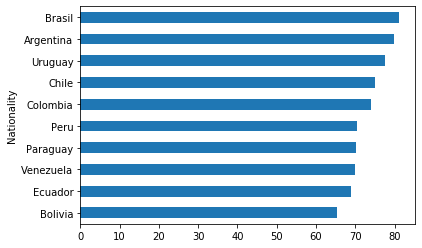

In [10]:
# Se visualiza el nivel de cada selección de acuerdo a la jerarquía de sus jugadores.

plot = potencial.sort_values( ascending=True).plot(kind='barh')

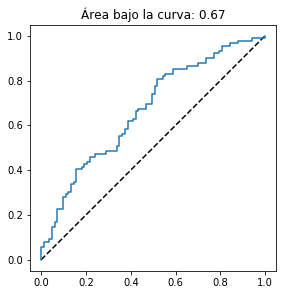

In [11]:
# Para predecir los resultados se construye un modelo de regresión lineal, cuyos predictores
# van a ser la diferencia en el ranking fifa y el nivel de los jugadores.

X, y = historico_conmebol.loc[:,['ranking_local', 'dif_ranking', 'diferencia_nivel']], historico_conmebol['gana_local']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regresion_logistica = linear_model.LogisticRegression(solver='lbfgs', C=1e-5)
features = PolynomialFeatures(degree=2)
modelo = Pipeline([('polynomial_features', features),('logistic_regression', regresion_logistica)])
modelo = modelo.fit(X_train, y_train)

fpr, tpr, _ = roc_curve(y_test, modelo.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('Área bajo la curva: {0:0.2}'.format(roc_auc_score(y_test, modelo.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

In [12]:
# Simulación de los partidos de la eliminatoria.

margen_error = 0.05
eliminatoria_conmebol['puntos'] = 0
eliminatoria_conmebol['probabilidad_total'] = 0
torneo_ordenado = sorted(set(eliminatoria_conmebol['grupo']))

print('ELIMINATORIA DE CONMEBOL:')
for grupo in torneo_ordenado:
    for local, visitante in combinations(eliminatoria_conmebol.query('grupo == "{}"'.format(grupo)).index, 2):
        print("{} vs. {}: ".format(local, visitante), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan]]), columns=X_test.columns)
        row['ranking_local'] = eliminatoria_conmebol.loc[local, 'ranking FIFA']
        opp_rank = eliminatoria_conmebol.loc[visitante, 'ranking FIFA']
        local_pot = eliminatoria_conmebol.loc[local, 'Overall']
        opp_pot = eliminatoria_conmebol.loc[visitante, 'Overall']
        row['dif_ranking'] = row['ranking_local'] - opp_rank 
        row['diferencia_nivel'] = local_pot - opp_pot  
        local_prob_triunfo = modelo.predict_proba(row)[:,1][0]
        eliminatoria_conmebol.loc[local, 'probabilidad_total'] += local_prob_triunfo
        eliminatoria_conmebol.loc[visitante, 'probabilidad_total'] += 1-local_prob_triunfo
        puntos = 0
        if local_prob_triunfo <= 0.5 - margen_error:
            print("{} triunfa con probabilidad de {:.3f}.".format(visitante, 1-local_prob_triunfo))
            eliminatoria_conmebol.loc[visitante, 'puntos'] += 3
        if local_prob_triunfo > 0.5 - margen_error:
            puntos = 1
        if local_prob_triunfo >= 0.5 + margen_error:
            puntos = 3
            eliminatoria_conmebol.loc[local, 'puntos'] += 3
            print("{} triunfa con probabilidad de {:.3f}.".format(local, local_prob_triunfo))
        if puntos == 1:
            print("Empate.")
            eliminatoria_conmebol.loc[local, 'puntos'] += 1
            eliminatoria_conmebol.loc[visitante, 'puntos'] += 1

ELIMINATORIA DE CONMEBOL:
Argentina vs. Bolivia: Argentina triunfa con probabilidad de 0.838.
Argentina vs. Brasil: Empate.
Argentina vs. Chile: Empate.
Argentina vs. Colombia: Empate.
Argentina vs. Ecuador: Argentina triunfa con probabilidad de 0.746.
Argentina vs. Paraguay: Argentina triunfa con probabilidad de 0.660.
Argentina vs. Peru: Argentina triunfa con probabilidad de 0.594.
Argentina vs. Uruguay: Empate.
Argentina vs. Venezuela: Argentina triunfa con probabilidad de 0.612.
Bolivia vs. Brasil: Brasil triunfa con probabilidad de 0.775.
Bolivia vs. Chile: Chile triunfa con probabilidad de 0.744.
Bolivia vs. Colombia: Colombia triunfa con probabilidad de 0.757.
Bolivia vs. Ecuador: Empate.
Bolivia vs. Paraguay: Paraguay triunfa con probabilidad de 0.635.
Bolivia vs. Peru: Peru triunfa con probabilidad de 0.708.
Bolivia vs. Uruguay: Uruguay triunfa con probabilidad de 0.774.
Bolivia vs. Venezuela: Venezuela triunfa con probabilidad de 0.691.
Brasil vs. Chile: Brasil triunfa con pr

In [13]:
# Visualizar a los cuatro que van directo al mundial y al que va a repechaje

eliminatoria_conmebol = eliminatoria_conmebol.sort_values(by=['grupo', 'puntos', 'probabilidad_total'], ascending=[True, False, False]).reset_index()
siguiente_fase = eliminatoria_conmebol.groupby('grupo').nth([0, 1, 2, 3]).reset_index()
siguiente_fase[['equipo', 'puntos']]

,equipo,puntos
0,Brasil,21
1,Argentina,19
2,Uruguay,17
3,Chile,16
